## A demo using Hydrogen Hamiltonian with GPT-QE.

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [1]:
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer

molecule = generate_molecule("Li", "H", 1.596, "sto-3g", bravyi_kitaev=False)
nqubit = 10

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=False)

# prepare operator_pool
uccsd = UCCSD(nqubit, molecule)
paulis = uccsd.paulis
paulis.append(PauliObservable("IIIIIIIIII"))
print('paulis', paulis)
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool,
                  [0.00625, -0.00625, 0.0125, -0.0125, 0.025, -0.025, 0.05, -0.05, 0.1, -0.1])


converged SCF energy = -1.11668438708534
Starting to parse FermionOperator using 4 qubits...

Operator t:  -0.09886396933545816 [] +
0.04532220205287399 [X0 Z1 X2] +
0.04532220205287399 [X0 Z1 X2 Z3] +
0.04532220205287399 [Y0 Z1 Y2] +
0.04532220205287399 [Y0 Z1 Y2 Z3] +
0.17119774903432977 [Z0] +
0.17119774903432972 [Z0 Z1] +
0.165867024105892 [Z0 Z1 Z2] +
0.165867024105892 [Z0 Z1 Z2 Z3] +
0.12054482205301804 [Z0 Z2] +
0.12054482205301804 [Z0 Z2 Z3] +
0.1686221915892094 [Z1] +
-0.2227859304041847 [Z1 Z2 Z3] +
0.17434844185575682 [Z1 Z3] +
-0.22278593040418473 [Z2]
Term, coeff:  () -0.09886396933545816
Term, coeff:  ((0, 'Z'),) 0.17119774903432977
Index, p_char:  0 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.17119774903432972
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.22278593040418473
Index, p_char:  2 Z
Term, coeff:  ((1, 'Z'), (2, 'Z'), (3, 'Z')) -0.2227859304041847
Index, p_char:  1 Z
Index, p_char:  2 Z
Index, p_char:  3 Z
Term, coeff:  ((1, 'Z'),) 0.1686221915

## FCI energy by diagonalization

In [3]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))

-1.137270174660903


## Setup for GPT

In [4]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 30  # The number of gates for each circuit
model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
model_config.embd_pdrop = 0
model_config.resid_pdrop = 0
model_config.attn_pdrop = 0
model = GPT(model_config, cost)

number of parameters: 85.24M


In [5]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 500
train_config.num_workers = 0
train_config.n_samples = 5
trainer = Trainer(train_config, model)

running on device cpu


In [6]:
def batch_end_callback(trainer):
    if trainer.iter_num % 1 == 0:
        print(
            f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f} temperature: {model.temperature}")
        model.temperature += 0.01


trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_test_2')

tensor([[ 75, 118,  90,  10,  99,  78,  81,  89,  23, 108,  78,  99,  81,  78,
          82,  81,  98,  99,  82,  78,  23,   6,  98,  76,  78,  78,  81,  77,
          78,  10],
        [ 81,  75,  49,  75,  27, 118, 105,  24, 100,  10,  75,  75, 100,  25,
          81,  90,  18,  23,  14,  98,  44,   1, 118,  98,  10,  36,  51, 118,
          31,  90],
        [ 78,  81, 115,  24,  24,  46,  87,  99,   2, 118,  90,  78,  40,  75,
          81,  90,  49,  75,  24, 100,  78, 100,  24,  87,  35,  98,  81,  35,
         102,  32],
        [ 78, 119,  90,  81, 105,  78,  64,  82,  49,  66,  66, 100,  81,  10,
          66,  78,  98,  99,  93,  13, 100,  14,  92,  30,  24,  99,  66,  99,
          78,  10],
        [ 90,  10, 100,  18,  78,  10,  20,  36,  13,  66,  98,  27, 113,  99,
          66,  20,  40,  23,  12,  98,  78,  75,  24,  14, 105,  40,  75,  35,
          98,  90]])
mean_logits tensor([-1.1184, -1.0651, -1.0625, -1.0450, -1.0035], grad_fn=<MeanBackward1>)
energies: tensor([

In [7]:
indices, logits = model.generate(torch.tensor([[0]]), model_config.n_gates)
print(cost.energy(indices))

tensor([-1.1267])


In [19]:
model.temperature = 20
model.load_state_dict(torch.load('../saved_models/gptqe_test_2'))
indices, logits = model.generate(torch.zeros(10, 1, dtype=torch.int), model_config.n_gates)
cost.sequence.tool = "qiskit"
index = torch.argmin(cost.energy(indices)).item()

tensor([-1.1347])
[ 66  66 113 113 113  31 113  66  66 113  31 113 113 113 113 113  31  31
  31 113  31 113 113 113  31 113  31   6 113  31]


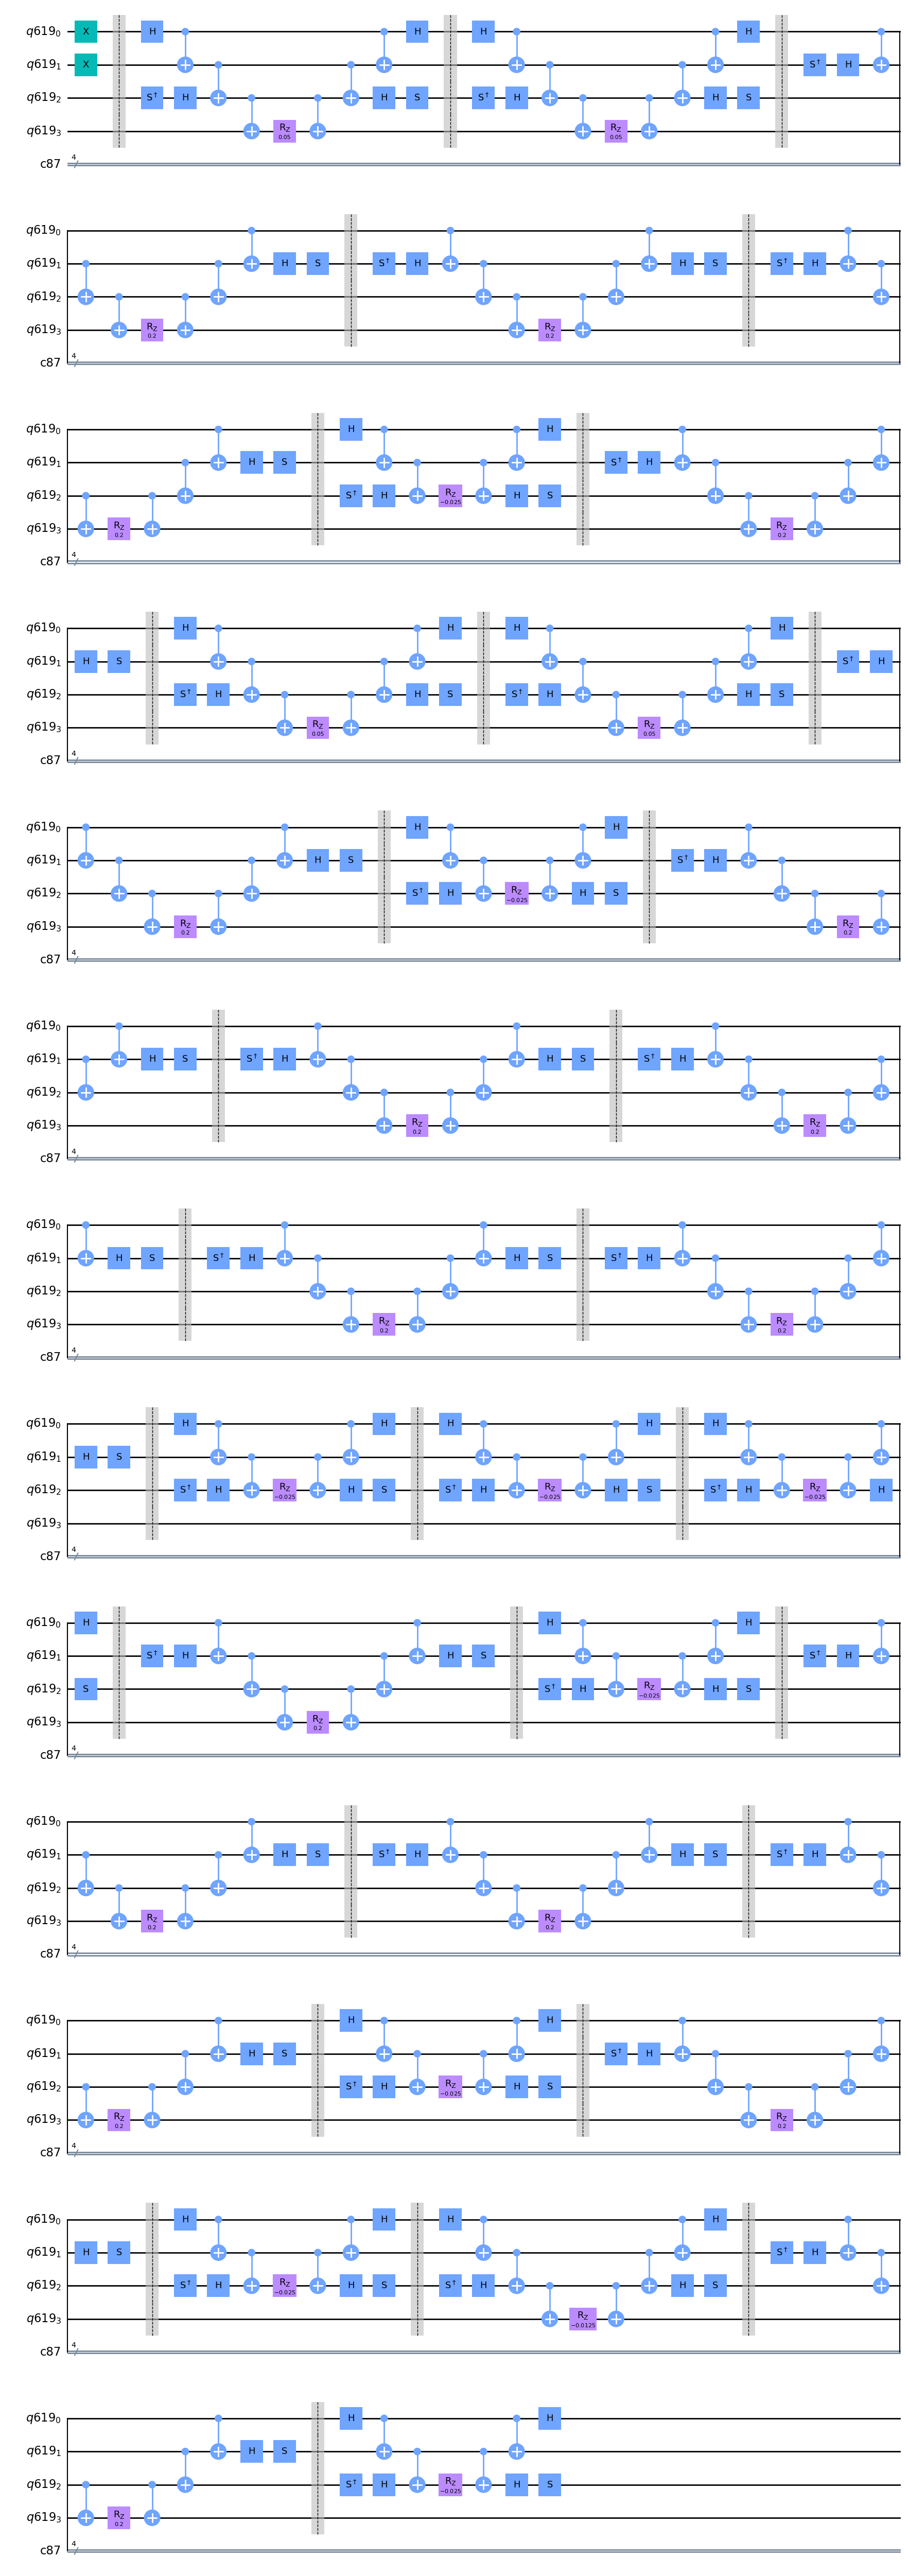

In [22]:
target = indices.numpy()[index]
print(cost.energy(torch.tensor([target])))
print(target)
cost.sequence._get_circuit(target).qc.draw(output="mpl", plot_barriers=True)